# Import Package

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn import*
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore')

# Data Loading

In [ ]:
url = 'https://drive.google.com/uc?id=1KklvbAJqeG86WZ_K5HjBMYWKYN6yVcV6'
df_ = pd.read_csv(url)

In [ ]:
df_.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Data Preparation

Cleaning Dataset and Handling Categorical Features

In [ ]:
df_.drop(df_[df_["gender"]=="Other"].index,inplace=True)
df_.reset_index(drop=True,inplace=True)

In [ ]:
one_hot_encoded_data = pd.get_dummies(df_, columns = ["gender", "smoking_history"])
df_ = pd.DataFrame(one_hot_encoded_data)

In [ ]:
df_= df_.rename(columns={"gender_Female":"female","gender_Male":"male","ever_married_No":"ma_no",
                         "smoking_history_No Info":"no_info_smoke","smoking_history_current":"current_smoke",
                        "smoking_history_ever":"ever_smoke","smoking_history_former":"former_smoke",
                        "smoking_history_never":"never_smoke","smoking_history_not current":"no_current_smoke",})
df_=df_.reindex(columns=['age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level','female','male',
                         'no_info_smoke','current_smoke','ever_smoke','former_smoke','never_smoke','no_current_smoke',
                         'diabetes'])

Dictonary for storing different method performance



In [ ]:
Compare = {"Method":[],"P_Count":[],"N_Count":[],"Score_P":[],"Score_N":[],"Score":[]}

The following function will be used to plot the sample space after resampling to illustrate the specificities of an algorithm.

In [ ]:
def plot_resampling(x_res, y_res, sampler, ax, title=None):
    x_res = pd.DataFrame(x_res)
    ax.scatter(x_res.iloc[:, 0], x_res.iloc[:, 3], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)

The following function will be used to plot the decision function of a classifier given some data.

In [ ]:
def plot_decision_function(x, y, clf, ax, title=None):
    x = pd.DataFrame(x)
    plot_step = 0.02
    x_min, x_max = x.iloc[:, 0].min() - 1, x.iloc[:, 0].max() + 1
    y_min, y_max = x.iloc[:, 3].min() - 1, x.iloc[:, 3].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    clf.fit(x.iloc[:, [0,3]],y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(x.iloc[:, 0], x.iloc[:, 3], alpha=0.8, c=y, edgecolor="k")
    if title is None:
        title = f"Decision function of {clf.__class__.__name__}"
    ax.set_title(title)

The following function will be used to plot the class label distribution.

In [ ]:
def shareplot(df,target):
    dfi = df.groupby(target).size().reset_index(name="Count")
    fig = px.pie(dfi, values='Count', names=target)
    fig.update_traces(textposition='auto', textinfo='percent+label',sort=False,showlegend=False,rotation=90)
    fig.update_layout(title_text='Class label shares',title_x=0.5)
    fig.show()

The following function will be used to show information about method performance and its score

In [ ]:
def info_func(df,target,method,ver=""):
    #Scaling the dataset using standard scaler
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns,columns = list(DF.drop(columns=target)))
    DFs[target] = DF[target]
    #--------------------------------------------------------------------------------------------------------------------------
    # Defining x_train  x_test  y_train  y_test using train_test_split
    ts = 0.15 #test size
    x = DFs.drop(columns=target).values
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=ts,random_state=308)
    #-------------------------------------------------------------------------------------------------------------------------------
    #Modeling
    model = LogisticRegression()
    model.fit(x_train,y_train)
    #-------------------------------------------------------------------------------------------------------------------------------
    # Accuracy Metrics
    # Accuracy given whole data to the model
    print("Accuray", metrics.accuracy_score(y,model.predict(x)))
    # Accuracy given test data to the model
    print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))
    # Accuracy given train data to the model
    print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))
    # Classification Report
    print(metrics.classification_report(y,model.predict(x)))
    #-------------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    cm = metrics.confusion_matrix(y,model.predict(x)) #confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    fig , ax = plt.subplots(figsize=(10,5))
    cm_display.plot(ax=ax)
    plt.show()
    #-------------------------------------------------------------------------------------------------------------------------------
    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i!=j:
                c += cm[i][j]
    ce = c/float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce*100}%")
    #-------------------------------------------------------------------------------------------------------------------------------
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method=="None":
        Compare["Method"].append("NoMethod")
    else:
        Compare["Method"].append(method.__class__.__name__+ver)
    Compare["P_Count"].append(dfi[dfi[target]==1].values[0][1])
    Compare["N_Count"].append(dfi[dfi[target]==0].values[0][1])
    Compare["Score_P"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["1"]["f1-score"])
    Compare["Score_N"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["0"]["f1-score"])
    Compare["Score"].append(metrics.accuracy_score(y,model.predict(x)))

In [ ]:
shareplot(df_,"diabetes")

Accuray 0.9603528635154328
Accuracy test:  0.9618615815442059
Accuracy train:  0.9600866045373246
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     91482
           1       0.87      0.63      0.73      8500

    accuracy                           0.96     99982
   macro avg       0.92      0.81      0.85     99982
weighted avg       0.96      0.96      0.96     99982



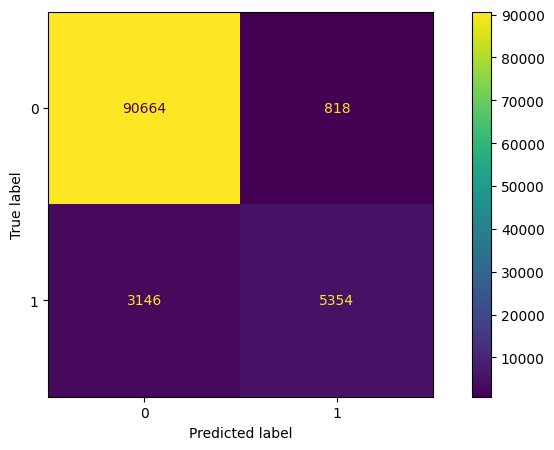

classification Error is : 3.964713648456722%


In [ ]:
info_func(df_,"diabetes","None")

In [ ]:
X = df_.drop(columns="diabetes").values
Y = df_["diabetes"].values.reshape(-1,1)

In [ ]:
for i in range(30):
    B_method = under_sampling.InstanceHardnessThreshold(random_state=42,n_jobs=-1)
    x_IHT , y_IHT = B_method.fit_resample(X,Y)
    X = x_IHT;Y = y_IHT
newdf = pd.DataFrame(x_IHT);newdf["diabetes"]=y_IHT
newdf = newdf.reset_index(drop=True)

In [ ]:
shareplot(newdf,"diabetes")

In [ ]:
DF = newdf.copy()
target = "diabetes"

In [ ]:
# Scaling dataset menggunakan standard scaler
scal_s = preprocessing.StandardScaler()
# Pisahkan fitur (X) dan target (Y) dari data yang sudah di-resample
X_resampled = DF.drop(columns=target).values
Y_resampled = DF[target].values.reshape(-1, 1)

In [ ]:
ts = 0.15 #test size
x_resampled = DF.drop(columns=target).values
y_resampled = DF[target].values.reshape(-1,1)

In [ ]:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    x_resampled, y_resampled, test_size=ts, random_state=308, stratify=y_resampled if len(np.unique(y_resampled)) > 1 else None
)

In [ ]:
# Scaling data latih dan uji secara terpisah
scaler = preprocessing.StandardScaler()

# Fit scaler pada data latih
scaler.fit(x_train_resampled)

# Terapkan scaler pada data latih dan uji
x_train_resampled_scaled = scaler.transform(x_train_resampled)
x_test_resampled_scaled = scaler.transform(x_test_resampled)

# Modeling

In [ ]:
model = LogisticRegression(random_state=308)
model.fit(x_train_resampled_scaled, y_train_resampled.ravel())

LogisticRegression(random_state=308)

In [ ]:
probabilities_test = model.predict_proba(x_test_resampled_scaled)

In [ ]:
print("\nProbabilitas prediksi pada data uji (setelah resampling dan scaling):")
# Gabungkan prediksi kelas dan probabilitas untuk tampilan yang lebih jelas
test_predictions = model.predict(x_test_resampled_scaled)
results_df = pd.DataFrame({
    'Actual': y_test_resampled.ravel(),
    'Predicted': test_predictions,
    'Prob_No_Diabetes': probabilities_test[:, 0],
    'Prob_Diabetes': probabilities_test[:, 1]
})
print(results_df.head())


Probabilitas prediksi pada data uji (setelah resampling dan scaling):
   Actual  Predicted  Prob_No_Diabetes  Prob_Diabetes
0       1          1      4.103295e-11       1.000000
1       0          0      9.999476e-01       0.000052
2       1          1      1.303690e-11       1.000000
3       1          1      3.700593e-10       1.000000
4       1          1      1.639685e-05       0.999984


In [ ]:
print("\nPerformance on the test set (after resampling and scaling):")
print("Accuracy:", metrics.accuracy_score(y_test_resampled, test_predictions))
print("Classification Report:")
print(metrics.classification_report(y_test_resampled, test_predictions))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test_resampled, test_predictions))
print("AUC-ROC:", metrics.roc_auc_score(y_test_resampled, probabilities_test[:, 1]))


Performance on the test set (after resampling and scaling):
Accuracy: 0.9939759036144579
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1713
           1       1.00      0.99      0.99      1275

    accuracy                           0.99      2988
   macro avg       0.99      0.99      0.99      2988
weighted avg       0.99      0.99      0.99      2988

Confusion Matrix:
[[1708    5]
 [  13 1262]]
AUC-ROC: 0.9998406648123348


# coba model

In [ ]:
if 'df_' in locals():
    df_positif_diabetes = df_[df_['diabetes'] == 0]
    print(df_positif_diabetes.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   female   male  no_info_smoke  current_smoke  ever_smoke  former_smoke  \
0    True  False          False          False       False         False   
1    True  False           True          False       False         False   
2   False   True          False          False       False         False   
3    True  False          False           True       False         False   
4   False   True          False           True       False         False   

   never_smoke  no_current_smoke  diabetes  
0         T

In [ ]:
# --- Bagian untuk memprediksi data user baru ---

# Langkah 1: Buat data user baru (contoh)
# Ganti nilai-nilai ini dengan data user yang sebenarnya
user_data = {
    'age': [20],
    'hypertension': [1],
    'heart_disease': [1],
    'bmi': [20.19],
    'HbA1c_level': [5.6],
    'blood_glucose_level': [40],
    'gender': ['Female'],
    'smoking_history': ['never']
}

user_df = pd.DataFrame(user_data)

print("Data user baru sebelum preprocessing:")
display(user_df) # Menggunakan display untuk tampilan yang lebih baik di Colab/Jupyter

# Langkah 2: Preprocessing data user baru
# Lakukan langkah preprocessing yang sama seperti pada data pelatihan

# 2a: Handle 'gender' == 'Other' (meskipun data baru tidak ada, penting untuk konsisten)
# user_df.drop(user_df[user_df["gender"]=="Other"].index,inplace=True) # Jika ada data 'Other'
# user_df.reset_index(drop=True,inplace=True) # Jika ada baris yang dihapus

# 2b: One-hot encode 'gender' dan 'smoking_history'
# Gunakan get_dummies. Pastikan kolom yang dihasilkan sama dengan data pelatihan.
user_one_hot = pd.get_dummies(user_df, columns = ["gender", "smoking_history"])

# 2c: Ganti nama kolom
user_one_hot = user_one_hot.rename(columns={
    "gender_Female":"female",
    "gender_Male":"male",
    # "ever_married_No":"ma_no", # Jika ever_married digunakan dan di-one-hot
    "smoking_history_No Info":"no_info_smoke",
    "smoking_history_current":"current_smoke",
    "smoking_history_ever":"ever_smoke",
    "smoking_history_former":"former_smoke",
    "smoking_history_never":"never_smoke",
    "smoking_history_not current":"no_current_smoke",
})

# 2d: Susun ulang kolom agar sesuai dengan urutan kolom pelatihan
# Dapatkan daftar kolom dari data pelatihan yang sudah di-resample dan di-scale
# Menggunakan kolom dari x_train_resampled_scaled (atau DF.drop(columns=target).columns jika newdf digunakan sebelum train/test split)
# training_columns sudah didefinisikan sebelumnya dan konsisten
training_columns = ['age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level','female','male',
                    'no_info_smoke','current_smoke','ever_smoke','former_smoke','never_smoke','no_current_smoke']

# Pastikan user_one_hot memiliki semua kolom di training_columns.
# Jika ada kolom yang hilang, tambahkan dengan nilai 0.
for col in training_columns:
    if col not in user_one_hot.columns:
        user_one_hot[col] = 0

# Sekarang susun ulang kolomnya
user_preprocessed = user_one_hot[training_columns]

# 2e: Scaling data user baru menggunakan scaler yang SAMA yang dilatih pada data pelatihan
# Pastikan objek 'scaler' dari bagian Modeling sudah tersedia dan dilatih
user_scaled_data = scaler.transform(user_preprocessed)

# Karena scaler.transform mengembalikan array numpy, ubah kembali menjadi DataFrame dengan nama kolom yang sama
user_preprocessed_scaled_df = pd.DataFrame(user_scaled_data, columns=user_preprocessed.columns)

print("\nData user baru setelah preprocessing dan scaling:")
display(user_preprocessed_scaled_df) # Menggunakan display

# Langkah 3: Mendapatkan probabilitas dari model yang sudah dilatih
# Gunakan model yang sudah dilatih (objek 'model')
probabilities_user = model.predict_proba(user_preprocessed_scaled_df)

# Probabilitas untuk kelas 0 (tidak diabetes) ada di kolom 0
prob_no_diabetes = probabilities_user[:, 0][0]

# Probabilitas untuk kelas 1 (diabetes) ada di kolom 1
prob_diabetes = probabilities_user[:, 1][0]

print(f"\nProbabilitas User Terkena Diabetes: {prob_diabetes:.4f} ({prob_diabetes*100:.2f}%)")
print(f"Probabilitas User Tidak Terkena Diabetes: {prob_no_diabetes:.4f} ({prob_no_diabetes*100:.2f}%)")

# Jika Anda ingin mendapatkan prediksi kelasnya (0 atau 1)
predicted_class = model.predict(user_preprocessed_scaled_df)[0]
print(f"\nPrediksi Kelas (0: Tidak Diabetes, 1: Diabetes): {predicted_class}")

Data user baru sebelum preprocessing:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender,smoking_history
0,20,1,1,20.19,5.6,40,Female,never



Data user baru setelah preprocessing dan scaling:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,female,male,no_info_smoke,current_smoke,ever_smoke,former_smoke,never_smoke,no_current_smoke
0,-0.670482,2.912113,3.829266,-0.805852,-0.042367,-1.879118,0.891827,-0.891827,-1.034495,-0.231037,-0.15111,-0.296353,1.55339,-0.194141



Probabilitas User Terkena Diabetes: 0.3169 (31.69%)
Probabilitas User Tidak Terkena Diabetes: 0.6831 (68.31%)

Prediksi Kelas (0: Tidak Diabetes, 1: Diabetes): 0


eksport model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import joblib
import os
import tensorflow as tf
from tensorflow import keras

# Assume 'model' is your trained scikit-learn LogisticRegression model
# Assume 'x_train_resampled_scaled' is your scaled training data
# For demonstration purposes, let's create dummy data if they don't exist
try:
    model
except NameError:
    from sklearn.linear_model import LogisticRegression
    from sklearn.datasets import make_classification
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    # Generate some dummy data
    X, y = make_classification(n_samples=100, n_features=10, random_state=42)
    scaler = StandardScaler()
    x_train_resampled_scaled = scaler.fit_transform(X)
    model = LogisticRegression()
    model.fit(x_train_resampled_scaled, y)
    print("Dummy scikit-learn model and data created for demonstration.")


# --- Original code for saving scikit-learn model ---
model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_filepath = os.path.join(model_dir, 'logistic_regression_model.joblib')
joblib.dump(model, model_filepath)
print(f"Scikit-learn model saved to: {model_filepath}")


# --- Original code for creating and setting weights for Keras model ---
num_features = x_train_resampled_scaled.shape[1]

keras_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(num_features,)),
    keras.layers.Dense(1, activation='sigmoid')
])

scikit_learn_weights = model.coef_.T
scikit_learn_bias = model.intercept_

keras_model.layers[0].set_weights([scikit_learn_weights, scikit_learn_bias])

keras_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

print("\nModel Keras setara berhasil dibuat dan bobot disalin.")
keras_model.summary()

# --- Original code for saving Keras model in SavedModel format ---
keras_model_savedmodel_dir = './keras_saved_model'
keras_model.export(keras_model_savedmodel_dir) # Use .export() for SavedModel format
print(f"\nModel Keras disimpan dalam format SavedModel ke: {keras_model_savedmodel_dir}")

# --- NEW: Save Keras model in .h5 format ---
keras_model_h5_filepath = './keras_model.h5'
keras_model.save(keras_model_h5_filepath)
print(f"\nModel Keras disimpan dalam format .h5 ke: {keras_model_h5_filepath}")

# --- Original code for TensorFlow.js conversion ---
# This part assumes you have tensorflowjs_converter installed and accessible in your environment.
# You would typically run this command in your terminal, not directly in a Python script
# unless you are using subprocess.
# For demonstration, we'll just print the command.
tfjs_output_dir = "./tfjs_model"
print(f"\nTo convert to TensorFlow.js, run this command in your terminal:")
print(f"!tensorflowjs_converter --input_format=tf_saved_model \"{keras_model_savedmodel_dir}\" \"{tfjs_output_dir}\"")
print(f"Model tfjs akan disimpan di {tfjs_output_dir}")

Scikit-learn model saved to: ./model/logistic_regression_model.joblib

Model Keras setara berhasil dibuat dan bobot disalin.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15 (60.00 B)

 Trainable params: 15 (60.00 B)

 Non-trainable params: 0 (0.00 B)

Saved artifact at './keras_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 14), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132364611846224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132364611849488: TensorSpec(shape=(), dtype=tf.resource, name=None)



Model Keras disimpan dalam format SavedModel ke: ./keras_saved_model

Model Keras disimpan dalam format .h5 ke: ./keras_model.h5

To convert to TensorFlow.js, run this command in your terminal:
!tensorflowjs_converter --input_format=tf_saved_model "./keras_saved_model" "./tfjs_model"
Model tfjs akan disimpan di ./tfjs_model


In [ ]:
!zip -r tfjs_model.zip ./tfjs_model

	zip warning: name not matched: ./tfjs_model

zip error: Nothing to do! (try: zip -r tfjs_model.zip . -i ./tfjs_model)


In [ ]:
import joblib
import os

# Pastikan direktori model ada
model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Path untuk menyimpan scaler
scaler_filepath = os.path.join(model_dir, 'scaler.joblib')

# Simpan objek scaler
joblib.dump(scaler, scaler_filepath)

print(f"Scaler saved to: {scaler_filepath}")

Scaler saved to: ./model/scaler.joblib


In [ ]:
!zip -r model.zip ./model

  adding: model/ (stored 0%)
  adding: model/scaler.joblib (deflated 19%)
  adding: model/logistic_regression_model.joblib (deflated 30%)
